# Аналитика: уровень сервиса AppScience

**Базовые задачи**
* Определение времени выставления коммерческого предложения;
* Проверка функционирования инструмента приоритизации;
* Оценка качества работы менеджеров по продажам.

**Вопросы**
* Сколько в среднем готовится КП?
* Как много КП готовится за 1, 2, 3 дня?
* Как размер сделки влияет на время выставления КП?
* Помогают ли тэги 'Репутационная сделка' и 'Срочный запрос' выставить КП быстрее?
* Если ли клиенты, которым КП выставляются долго или быстро?

**Краткие ответы**
* 2 дня 22:41:31;
* 1599, 762, 724;
* Крупные сделки выставляются незначительно дольше;
* Скорее нет, чем да;
* Да: 195 клиентов, которым КП выставляются быстро, и 13, которым выставляются долго..

**Исходные данные**  
База данных `datawarehouse` (для начала рассмотрим таблицу `amocrm_deals`, содержащую информацию о всех сделках).

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode

## Изучение данных из файла

In [2]:
try:
    deals_data = pd.read_csv('amocrm_deals.csv')
except OSError as error:
    print(error)

In [3]:
def overview_df(data):
    display(data.head())
    data.info()

In [4]:
overview_df(deals_data)

,Company ID,Created At,ID,Supply Deadline2,Responsible User ID,Pay Condition ID,Pay Condition Desc,Status ID,Bill Number,Is Deleted,...,Delivery City,Contract Number,Proposal Currency,Money Received,Offer Man,Source,Payment Deadline,Payment Days Type,Days For Payment,Bill Pdf URL
0,13972007,2021-08-19T16:22:40+03:00,14596035,1632960000,7044196,519145,Предоплата,142,1376,False,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
1,13076667,2021-07-20T09:46:10+03:00,14082937,0,6611476,0,NaN,143,1055,False,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
2,20244751,2022-01-26T17:01:28+03:00,16844453,1652659200,7542451,519143,Постоплата,35818147,748,False,...,москва,0.0,USD,0.0,Даниил,NaN,0.0,workdays,30.0,NaN
3,18483639,2022-04-12T16:02:53+03:00,17892557,0,7603156,0,NaN,143,0,False,...,Москва,0.0,USD,0.0,Даниил,NaN,0.0,NaN,0.0,NaN
4,13076669,2022-06-15T15:19:53+03:00,18593211,0,7398229,0,NaN,35818369,0,False,...,Сергиев Посад,0.0,RUB,0.0,Анастасия Троякова,NaN,0.0,NaN,0.0,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13870 entries, 0 to 13869
Data columns (total 52 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Company ID                       13870 non-null  int64  
 1   Created At                       13870 non-null  object 
 2   ID                               13870 non-null  int64  
 3   Supply Deadline2                 13870 non-null  int64  
 4   Responsible User ID              13870 non-null  int64  
 5   Pay Condition ID                 13870 non-null  int64  
 6   Pay Condition Desc               5205 non-null   object 
 7   Status ID                        13870 non-null  int64  
 8   Bill Number                      13870 non-null  int64  
 9   Is Deleted                       13870 non-null  bool   
 10  Updated At                       13870 non-null  int64  
 11  Approved At                      13870 non-null  int64  
 12  Price             

При первичном изучении данных были выявлены следующие проблемы:
* Наличие пропусков в столбце `Status Time Proposal Sent`;
* Пустые столбцы `Tags Text` и `Contact Ids Text`;
* Несоответствие типов данных в столбцах `Created At` и `Status Time ...`.

## Подготовка данных

### Обработка пропусков

Выведем столбец `Status Time Proposal Sent`

In [5]:
overview_df(pd.DataFrame(deals_data['Status Time Proposal Sent']))

,Status Time Proposal Sent
0,2021-09-02T10:26:33+03:00
1,2021-07-20T10:07:38+03:00
2,2022-02-21T17:44:46+03:00
3,1970-01-01T03:00:00+03:00
4,1970-01-01T03:00:00+03:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13870 entries, 0 to 13869
Data columns (total 1 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Status Time Proposal Sent  13854 non-null  object
dtypes: object(1)
memory usage: 108.5+ KB


Столбец содержит фактическую информацию, поэтому мы не можем заполнить пустоты самостоятельно. Следовательно, исключим эти строки из исследования.  
Обратим внимание на то, что помимо пропусков в столбце присутствует некорректная дата — 1970-01-01T03:00:00+03:00. По всей видимости, она была добавлена системой **amocrm** автоматически.
Так как мы анализируем выставленные коммерческие предложения, будет уместно устранить данные строки тоже.

In [6]:
deals_data = deals_data.loc[(deals_data['Status Time Proposal Sent'] != '1970-01-01T03:00:00+03:00') 
                            & (deals_data['Status Time Proposal Sent'].notna())]

overview_df(deals_data)

,Company ID,Created At,ID,Supply Deadline2,Responsible User ID,Pay Condition ID,Pay Condition Desc,Status ID,Bill Number,Is Deleted,...,Delivery City,Contract Number,Proposal Currency,Money Received,Offer Man,Source,Payment Deadline,Payment Days Type,Days For Payment,Bill Pdf URL
0,13972007,2021-08-19T16:22:40+03:00,14596035,1632960000,7044196,519145,Предоплата,142,1376,False,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
1,13076667,2021-07-20T09:46:10+03:00,14082937,0,6611476,0,NaN,143,1055,False,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
2,20244751,2022-01-26T17:01:28+03:00,16844453,1652659200,7542451,519143,Постоплата,35818147,748,False,...,москва,0.0,USD,0.0,Даниил,NaN,0.0,workdays,30.0,NaN
6,13076889,2022-04-15T12:31:14+03:00,17922813,0,7555906,0,NaN,35818141,0,False,...,Саранск,0.0,USD,0.0,Рустам,NaN,0.0,NaN,0.0,NaN
7,23492037,2022-04-28T16:58:18+03:00,18044151,0,8021230,0,NaN,44209792,0,False,...,Новосибирск,0.0,RUB,0.0,Айнур,NaN,0.0,NaN,0.0,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9145 entries, 0 to 13868
Data columns (total 52 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Company ID                       9145 non-null   int64  
 1   Created At                       9145 non-null   object 
 2   ID                               9145 non-null   int64  
 3   Supply Deadline2                 9145 non-null   int64  
 4   Responsible User ID              9145 non-null   int64  
 5   Pay Condition ID                 9145 non-null   int64  
 6   Pay Condition Desc               4296 non-null   object 
 7   Status ID                        9145 non-null   int64  
 8   Bill Number                      9145 non-null   int64  
 9   Is Deleted                       9145 non-null   bool   
 10  Updated At                       9145 non-null   int64  
 11  Approved At                      9145 non-null   int64  
 12  Price              

### Обработка пустых столбцов

Удалим пустые столбцы и `Is Deleted`, так как он содержит исключительно значения false.

In [7]:
deals_data = deals_data.drop(columns=['Tags Text', 'Contact Ids Text', 'Is Deleted'])

### Преобразование типов данных

Для начала отметим, что столбцы `Status Time Success`, `Status Time Waiting For Payment`, `Status Time Hold`, `Status Time New Proposal`, `Status Time Cancel`, `Status Time Active Proposal`, `Status Time Received`, `Status Time Agreed` и `Status Time Paid By Company` вместо даты или хотя бы строки, содержат данные типа `float64`.  
Столбцы содержат фактическую информацию, поэтому мы не можем заполнить пустоты самостоятельно. Следовательно, исключим их из таблицы.

In [8]:
deals_data = deals_data.drop(columns=['Status Time Success', 'Status Time Waiting For Payment', 
                                      'Status Time New Proposal', 'Status Time Cancel',
                                     'Status Time Active Proposal', 'Status Time Received',
                                     'Status Time Agreed', 'Status Time Paid By Company'])

То же самое, вообще говоря, касается столбцов `Supply Deadline2`, `Updated At`, `Approved At`, `Closet At`, `Closest Task At`, `Supply Date`и `Supply Deadline`.

In [9]:
deals_data = deals_data.drop(columns=['Supply Deadline2', 'Updated At', 
                                      'Approved At', 'Closet At',
                                     'Closest Task At', 'Supply Date',
                                     'Supply Deadline'])
overview_df(deals_data)

,Company ID,Created At,ID,Responsible User ID,Pay Condition ID,Pay Condition Desc,Status ID,Bill Number,Price,Pipeline ID,...,Delivery City,Contract Number,Proposal Currency,Money Received,Offer Man,Source,Payment Deadline,Payment Days Type,Days For Payment,Bill Pdf URL
0,13972007,2021-08-19T16:22:40+03:00,14596035,7044196,519145,Предоплата,142,1376,17380,3679690,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
1,13076667,2021-07-20T09:46:10+03:00,14082937,6611476,0,NaN,143,1055,12500,3679690,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN
2,20244751,2022-01-26T17:01:28+03:00,16844453,7542451,519143,Постоплата,35818147,748,738240,3679690,...,москва,0.0,USD,0.0,Даниил,NaN,0.0,workdays,30.0,NaN
6,13076889,2022-04-15T12:31:14+03:00,17922813,7555906,0,NaN,35818141,0,4111,3679690,...,Саранск,0.0,USD,0.0,Рустам,NaN,0.0,NaN,0.0,NaN
7,23492037,2022-04-28T16:58:18+03:00,18044151,8021230,0,NaN,44209792,0,1380080,3679690,...,Новосибирск,0.0,RUB,0.0,Айнур,NaN,0.0,NaN,0.0,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9145 entries, 0 to 13868
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Company ID                 9145 non-null   int64  
 1   Created At                 9145 non-null   object 
 2   ID                         9145 non-null   int64  
 3   Responsible User ID        9145 non-null   int64  
 4   Pay Condition ID           9145 non-null   int64  
 5   Pay Condition Desc         4296 non-null   object 
 6   Status ID                  9145 non-null   int64  
 7   Bill Number                9145 non-null   int64  
 8   Price                      9145 non-null   int64  
 9   Pipeline ID                9145 non-null   int64  
 10  Loss Reason ID             9145 non-null   int64  
 11  Seller Company Desc        5466 non-null   object 
 12  Spreadsheet URL            4300 non-null   object 
 13  Created By                 9145 non-null   int6

Возможно, есть еще некоторые столбцы, которые нам не пригодятся, но пока оставим таблицу в таком виде.

Теперь поменяем тип данных в столбцах, которые должны содержать дату, с `object` на `datetime`.

In [10]:
deals_data['Created At'] = pd.to_datetime(deals_data['Created At'], format="%Y-%m-%dT%H:%M:%S+03:00")
print(f"Тип данных столбца {deals_data['Created At'].name}: {deals_data['Created At'].dtype}")

deals_data['Status Time Proposal Sent'] = pd.to_datetime(
    deals_data['Status Time Proposal Sent'], format="%Y-%m-%dT%H:%M:%S+03:00")
print(f"Тип данных столбца {deals_data['Status Time Proposal Sent'].name}: {deals_data['Status Time Proposal Sent'].dtype}")

Тип данных столбца Created At: datetime64[ns]
Тип данных столбца Status Time Proposal Sent: datetime64[ns]


### 1. Определение времени выставления коммерческого предложения

Рассчитаем время выставления КП как разность между датами `Created At` (создание записи в **amocrm**) и `Status Time Proposal Sent` (время отправки КП) и запишем в новый столбец `Proposal Send Time`.

In [11]:
deals_data['Proposal Send Time'] = (deals_data['Status Time Proposal Sent'] - deals_data['Created At'])

pd.DataFrame(deals_data['Proposal Send Time'])

,Proposal Send Time
0,13 days 18:03:53
1,0 days 00:21:28
2,26 days 00:43:18
6,45 days 06:41:33
7,32 days 08:22:32
...,...
13862,0 days 00:24:21
13863,0 days 04:08:42
13866,1 days 08:20:02
13867,24 days 23:30:59


Кроме того, добавим столбец `Status Time Proposal Sent ID`, обозначающий количество, потраченных на выставление КП — он понадобится для некоторых дальнейших расчетов. 

In [12]:
deals_data['Proposal Send Time ID'] = pd.to_numeric(
    deals_data['Proposal Send Time'].round('d').astype(str).str.replace(" days", ""))

pd.DataFrame(deals_data[['Proposal Send Time', 'Proposal Send Time ID']])

,Proposal Send Time,Proposal Send Time ID
0,13 days 18:03:53,14
1,0 days 00:21:28,0
2,26 days 00:43:18,26
6,45 days 06:41:33,45
7,32 days 08:22:32,32
...,...,...
13862,0 days 00:24:21,0
13863,0 days 04:08:42,0
13866,1 days 08:20:02,1
13867,24 days 23:30:59,25


#### Сколько в среднем готовится коммерческое предложение?

Построим гистограмму распределения количества КП по дням, потраченных на их выставление (0 означает, что КП было выставлено в течение ~12 часов).

In [13]:
deals_grouped_by_day = deals_data.groupby(['Proposal Send Time ID']).agg({'Proposal Send Time': ['count']})
deals_grouped_by_day

,Proposal Send Time
,count
Proposal Send Time ID,
0,1958
1,1599
2,762
3,724
4,549
...,...
225,1
236,1


In [14]:
min_days = deals_grouped_by_day['Proposal Send Time', 'count'].min()
print('{count}: {index}'.format(count= min_days, 
                                index=(deals_grouped_by_day[deals_grouped_by_day['Proposal Send Time', 'count'] == 
                                                            min_days]).index))

max_days = deals_grouped_by_day['Proposal Send Time', 'count'].max()
print('{count}: {index}'.format(count= max_days,
                                index=(deals_grouped_by_day[deals_grouped_by_day['Proposal Send Time', 'count'] == 
                                                            max_days]).index))

1: Int64Index([ 47,  71,  74,  79,  80,  82,  88,  89,  90,  93,  94,  97, 100,
            105, 106, 108, 112, 114, 115, 118, 119, 123, 125, 126, 127, 133,
            138, 140, 146, 149, 150, 154, 157, 163, 168, 172, 181, 221, 225,
            236, 257, 264, 638],
           dtype='int64', name='Proposal Send Time ID')
1958: Int64Index([0], dtype='int64', name='Proposal Send Time ID')


Получаем, что:
* меньше всего КП (**1**) было отправлено за 47, 71, 74,  79,  80,  82,  88,  89,  90,  93,  94,  97, 100, 105, 106, 108, 112, 114, 115, 118, 119, 123, 125, 126, 127, 133, 138, 140, 146, 149, 150, 154, 157, 163, 168, 172, 181, 221, 225, 236, 257, 264 и 638 дня;
* больше всего КП (**1958**) было отправлено в течение одного дня.

<BarContainer object of 134 artists>

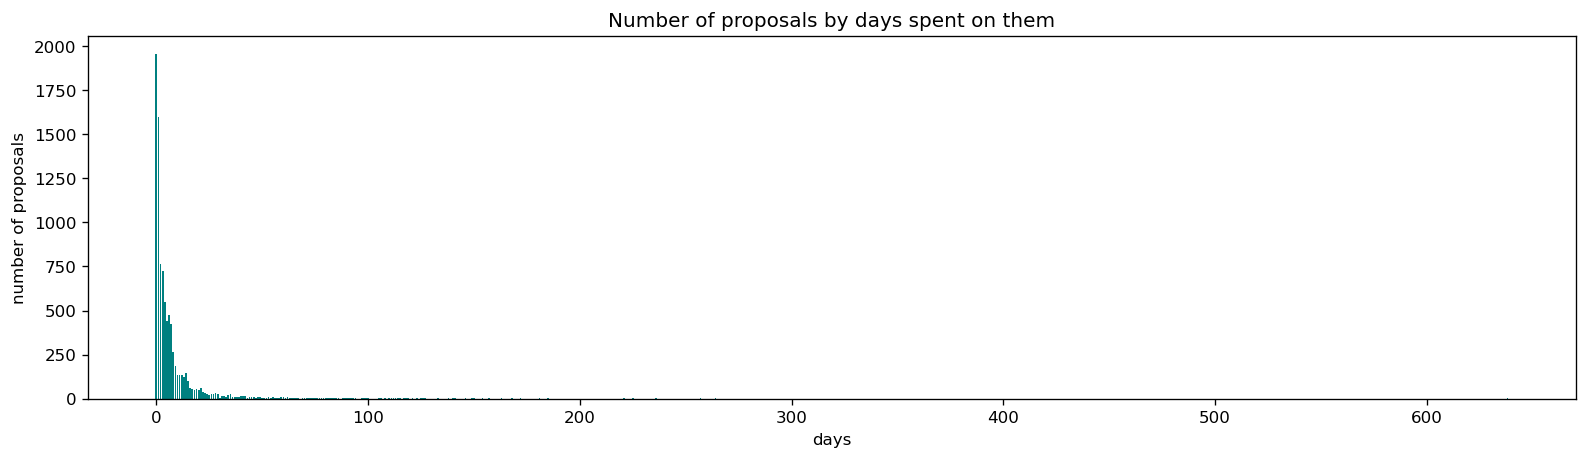

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(16, 4), dpi=120)
axs.set_title('Number of proposals by days spent on them')
axs.set_xlabel('days')
axs.set_ylabel('number of proposals')
axs.bar(deals_grouped_by_day.index, deals_grouped_by_day['Proposal Send Time', 'count'], color='teal')

Так как разброс количества дней, потраченных на выставление КП очень велик (от 0 до 638), определим среднее время подготовки КП как медиану.

In [16]:
print(deals_data['Proposal Send Time'].median())

2 days 22:41:31


Таким образом, среднее время подготовки КП равно **2 дням, 22 часам, 41 минуте, 31 секунде**.

#### Как много КП готовится за 1, 2, 3 дня?

Также определим, сколько КП готовится в течение ~12 часов.  
Добавим столбец `percentage`, содержащий информацию о том, какую долю они составляют от общего числа КП.

In [17]:
deals_grouped_by_day = deals_grouped_by_day.loc[deals_grouped_by_day.index < 4]
deals_grouped_by_day['Proposal Send Time', 'percentage'] = round(deals_grouped_by_day['Proposal Send Time', 'count'] 
                                                                 / len(deals_data), 4) * 100
deals_grouped_by_day

<ipython-input-17-e80b803dc757>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deals_grouped_by_day['Proposal Send Time', 'percentage'] = round(deals_grouped_by_day['Proposal Send Time', 'count']


Proposal Send Time           
                                   count percentage
Proposal Send Time ID                              
0                                   1958      21.41
1                                   1599      17.48
2                                    762       8.33
3                                    724       7.92

In [18]:
print('0-3: {}%'.format(deals_grouped_by_day['Proposal Send Time', 'percentage'].sum()))

0-3: 55.14%


Таким образом, мы выяснили, что **больше половины** КП готовятся за три дня и меньше — будем считать, что это *быстро*.  
Также определимся, что если КП готовится больше, чем две недели, то это *долго*.

#### Как размер сделки влияет на время выставления КП?

Добавим в рассмотрение таблицу `proposal_requests_items`, содержащую информацию о товарах, выставленных в сделках.

In [19]:
try:
    items_data = pd.read_csv('proposal_requests_items.csv')
except OSError as error:
    print(error)

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [20]:
overview_df(items_data)

,Deal ID,Ts,Created Date,Approved Date,Budjet,Client Name,User Name,Excel Created Date,ID,Vendor,...,Customs Fees Usd,Inbound Ru Usd,Lastmile Usd,Cost Per Unit Usd,Cost Per Unit Rub,Client Price Currency,Margin Per Unit Percent,Margin Per Unit Usdrub,Client Price Per Unit Usdrub,Total Cost Per Client
0,4188769,1654261490,2020-09-03,2022-06-14,54520,Изварино Фарма,Сергей Тепляков,2022-06-03,Reagecon -3008400-1 L,Reagecon,...,32,3,46,522,34947,RUB,30%,10484,54518,54520.0
1,11393617,1655391983,2021-02-18,2022-02-22,890810,Нита-Фарм,Аня Ильина,2022-06-16,Microbiologics-0671P-Set of STIKS,Microbiologics,...,15,15,38,255,17869,RUB,30%,5361,27876,27880.0
2,11393617,1655391983,2021-02-18,2022-02-22,890810,Нита-Фарм,Аня Ильина,2022-06-16,Microbiologics-0392L-Sets and Panels,Microbiologics,...,22,15,38,386,27020,RUB,30%,8106,42152,42150.0
3,11393617,1655391983,2021-02-18,2022-02-22,890810,Нита-Фарм,Аня Ильина,2022-06-16,Microbiologics-0123L-2 self-contained units of...,Microbiologics,...,42,30,38,682,47739,RUB,30%,14322,74474,74470.0
4,15373683,1655192511,2021-10-12,2021-10-25,408220,ПФК Обновление,Лера,2022-06-14,Sigma-Aldrich-8201120100-100 G,Sigma-Aldrich,...,14,3,37,0,0,RUB,30%,0,0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35969 entries, 0 to 35968
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Deal ID                       35969 non-null  int64  
 1   Ts                            35969 non-null  int64  
 2   Created Date                  35969 non-null  object 
 3   Approved Date                 35969 non-null  object 
 4   Budjet                        35969 non-null  int64  
 5   Client Name                   35936 non-null  object 
 6   User Name                     35969 non-null  object 
 7   Excel Created Date            35969 non-null  object 
 8   ID                            35969 non-null  object 
 9   Vendor                        16216 non-null  object 
 10  Brand                         3416 non-null   object 
 11  Catalogue ID                  21142 non-null  object 
 12  Cas ID                        9955 non-null   object 
 13  P

Каждой сделке может соответствовать несколько строк, то есть несколько видов товаров.  
Запишем эту информацию в новый столбец `Number Of Items`.

In [21]:
items_data = items_data.sort_values(by='Deal ID', ascending=True)
value_counts = items_data['Deal ID'].value_counts().sort_index().values
items_data = items_data.drop_duplicates(subset='Deal ID', keep='first')

items_data['Number Of Items'] = value_counts
overview_df(items_data)

,Deal ID,Ts,Created Date,Approved Date,Budjet,Client Name,User Name,Excel Created Date,ID,Vendor,...,Inbound Ru Usd,Lastmile Usd,Cost Per Unit Usd,Cost Per Unit Rub,Client Price Currency,Margin Per Unit Percent,Margin Per Unit Usdrub,Client Price Per Unit Usdrub,Total Cost Per Client,Number Of Items
0,4188769,1654261490,2020-09-03,2022-06-14,54520,Изварино Фарма,Сергей Тепляков,2022-06-03,Reagecon -3008400-1 L,Reagecon,...,3,46,522,34947,RUB,30%,10484,54518,54520.0,1
1,11393617,1655391983,2021-02-18,2022-02-22,890810,Нита-Фарм,Аня Ильина,2022-06-16,Microbiologics-0671P-Set of STIKS,Microbiologics,...,15,38,255,17869,RUB,30%,5361,27876,27880.0,3
4,15373683,1655192511,2021-10-12,2021-10-25,408220,ПФК Обновление,Лера,2022-06-14,Sigma-Aldrich-8201120100-100 G,Sigma-Aldrich,...,3,37,0,0,RUB,30%,0,0,0.0,1
5,15531623,1655306682,2021-10-22,1970-01-01,1,СПбГУ Химфак,Степан Негодов,2022-06-15,Sigma-Aldrich-381292-500G-500 G,Sigma-Aldrich,...,3,224,1231,82137,USD,30%,24641,128134,128134.0,1
6,16021901,1650441680,2021-11-24,2022-04-28,138890,ПСК Фарма (Rus Biopharm),Катя Мишина,2022-04-20,--,NaN,...,0,0,0,0,RUB,NaN,0,0,0.0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5258 entries, 0 to 35967
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Deal ID                       5258 non-null   int64  
 1   Ts                            5258 non-null   int64  
 2   Created Date                  5258 non-null   object 
 3   Approved Date                 5258 non-null   object 
 4   Budjet                        5258 non-null   int64  
 5   Client Name                   5252 non-null   object 
 6   User Name                     5258 non-null   object 
 7   Excel Created Date            5258 non-null   object 
 8   ID                            5258 non-null   object 
 9   Vendor                        2530 non-null   object 
 10  Brand                         512 non-null    object 
 11  Catalogue ID                  3204 non-null   object 
 12  Cas ID                        1383 non-null   object 
 13  Pa

Будем считать сделку *мелкой*, если количество позиций в ней 3 и меньше, *средней* — от 4 до 9, *крупной* — 10+. Введем столбец `Deal Size Category` с соответствующими метками (0 — *мелкая*, 1 — *средняя*, 2 — *крупная*).

In [22]:
def size_categorize(row):
    size = row['Number Of Items']
    if size <= 3:
        return 'small'
    elif (3 < size < 10) :
        return 'medium'
    else:
        return 'large'
    
items_data['Deal Size Category'] = items_data.apply(size_categorize, axis=1)
items_data

,Deal ID,Ts,Created Date,Approved Date,Budjet,Client Name,User Name,Excel Created Date,ID,Vendor,...,Lastmile Usd,Cost Per Unit Usd,Cost Per Unit Rub,Client Price Currency,Margin Per Unit Percent,Margin Per Unit Usdrub,Client Price Per Unit Usdrub,Total Cost Per Client,Number Of Items,Deal Size Category
0,4188769,1654261490,2020-09-03,2022-06-14,54520,Изварино Фарма,Сергей Тепляков,2022-06-03,Reagecon -3008400-1 L,Reagecon,...,46,522,34947,RUB,30%,10484,54518,54520.0,1,small
1,11393617,1655391983,2021-02-18,2022-02-22,890810,Нита-Фарм,Аня Ильина,2022-06-16,Microbiologics-0671P-Set of STIKS,Microbiologics,...,38,255,17869,RUB,30%,5361,27876,27880.0,3,small
4,15373683,1655192511,2021-10-12,2021-10-25,408220,ПФК Обновление,Лера,2022-06-14,Sigma-Aldrich-8201120100-100 G,Sigma-Aldrich,...,37,0,0,RUB,30%,0,0,0.0,1,small
5,15531623,1655306682,2021-10-22,1970-01-01,1,СПбГУ Химфак,Степан Негодов,2022-06-15,Sigma-Aldrich-381292-500G-500 G,Sigma-Aldrich,...,224,1231,82137,USD,30%,24641,128134,128134.0,1,small
6,16021901,1650441680,2021-11-24,2022-04-28,138890,ПСК Фарма (Rus Biopharm),Катя Мишина,2022-04-20,--,NaN,...,0,0,0,RUB,NaN,0,0,0.0,1,small
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35962,18681085,1655892267,2022-06-22,1970-01-01,0,Эвалар,Юля Рязанцева,2022-06-22,-PHL89651-25MG-25 MG,Sigma-Aldrich,...,4,468,29142,USD,30%,140,730,1460.0,2,small
35964,18681125,1655892094,2022-06-22,1970-01-01,0,Скопинфарм,Сергей Тепляков,2022-06-22,Sigma-Aldrich-A6338-250UN-250 UNITS,Sigma-Aldrich,...,50,683,42496,RUB,30%,205,1065,1065.0,1,small
35965,18681149,1655892141,2022-06-22,1970-01-01,0,Акрихин,Света Жилова,2022-06-22,-141020.1611-1'000 milliliter,Panreac,...,50,0,0,RUB,30%,0,0,0.0,1,small
35966,18681265,1655892759,2022-06-22,1970-01-01,0,Фармстандарт-УфаВИТА,Оливия,2022-06-22,Sigma-Aldrich-SMB00118-1MG-1 MG,Sigma-Aldrich,...,157,1415,29370,RUB,30%,142,736,2208.0,1,small


Теперь объединим таблицы `amocrm_deals` и `proposal_requests_items` по столбцам `ID` и `Deal ID` в таблицу `result_data`.

In [23]:
result_data = deals_data.merge(items_data, how='left', left_on='ID', right_on='Deal ID')
result_data = result_data.sort_values(by='ID_x', ascending=True)
overview_df(result_data)

,Company ID,Created At,ID_x,Responsible User ID,Pay Condition ID,Pay Condition Desc,Status ID,Bill Number,Price,Pipeline ID,...,Lastmile Usd,Cost Per Unit Usd,Cost Per Unit Rub,Client Price Currency,Margin Per Unit Percent,Margin Per Unit Usdrub,Client Price Per Unit Usdrub,Total Cost Per Client,Number Of Items,Deal Size Category
9108,15439373,2020-09-03 09:02:41,4188769,8209654,519145,Предоплата,35818147,1376,54520,3679690,...,46.0,522.0,34947.0,RUB,30%,10484.0,54518.0,54520.0,1.0,small
7114,12908443,2020-11-04 18:06:19,7350861,6445000,519143,Постоплата,142,47,89750,3679690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4386,13085271,2020-11-04 18:06:55,7350873,6473404,0,NaN,143,0,0,3679690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4754,12470263,2020-11-04 18:07:46,7350897,6142522,0,NaN,143,0,0,3679690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2146,15753735,2020-11-04 18:08:21,7350907,6142522,0,NaN,143,0,987000,3679690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9145 entries, 9108 to 1606
Data columns (total 73 columns):
 #   Column                        Non-Null Count  Dtype          
---  ------                        --------------  -----          
 0   Company ID                    9145 non-null   int64          
 1   Created At                    9145 non-null   datetime64[ns] 
 2   ID_x                          9145 non-null   int64          
 3   Responsible User ID           9145 non-null   int64          
 4   Pay Condition ID              9145 non-null   int64          
 5   Pay Condition Desc            4296 non-null   object         
 6   Status ID                     9145 non-null   int64          
 7   Bill Number                   9145 non-null   int64          
 8   Price                         9145 non-null   int64          
 9   Pipeline ID                   9145 non-null   int64          
 10  Loss Reason ID                9145 non-null   int64          
 11  Seller Company

Text(0.5, 1.0, 'Smaller Scale')

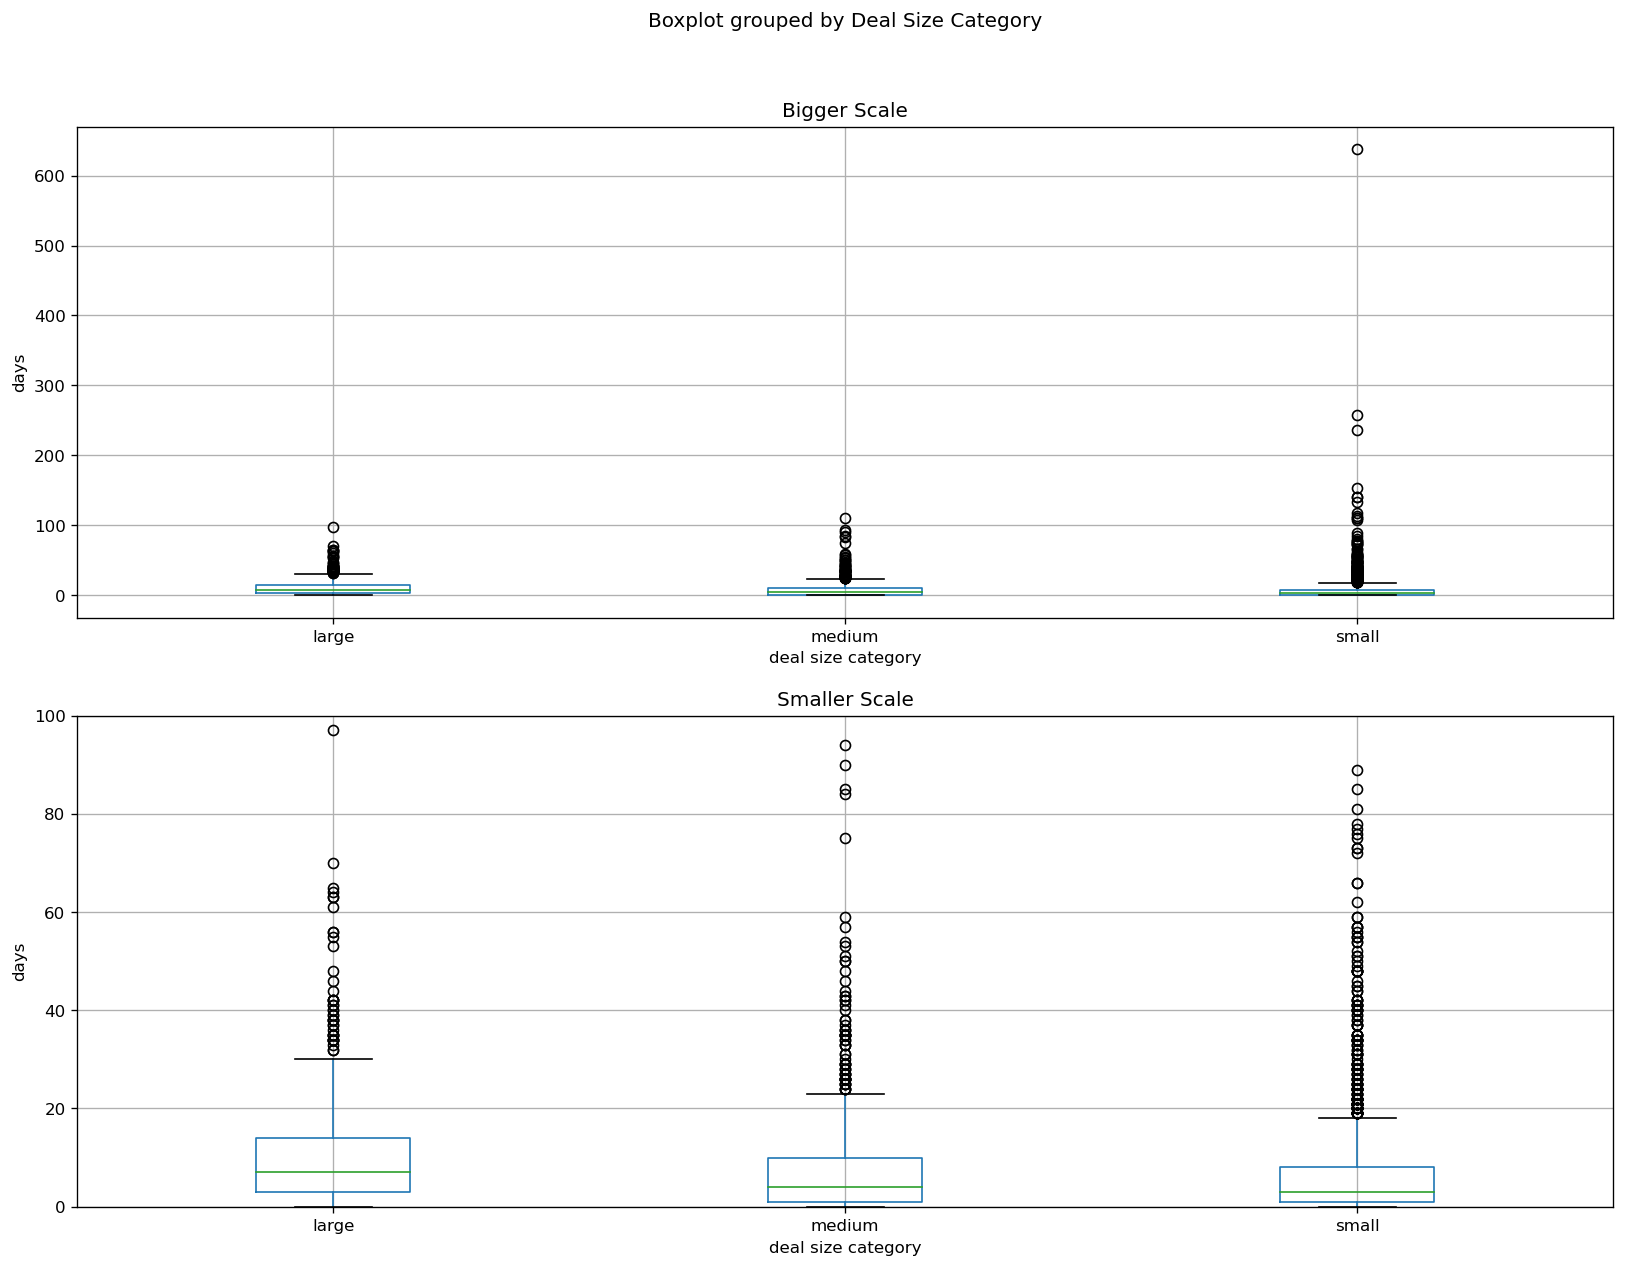

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(16, 12), dpi=120)

result_data.boxplot(column='Proposal Send Time ID', by='Deal Size Category', ax=axs[0])
result_data.boxplot(column='Proposal Send Time ID', by='Deal Size Category', ax=axs[1])

for i in range(2):
    axs[i].set_xlabel('deal size category')
    axs[i].set_ylabel('days')
    

axs[1].set_ylim(0, 1e2)
axs[0].set_title('Bigger Scale')
axs[1].set_title('Smaller Scale')

In [25]:
result_data['Deal Size Category'].value_counts()

small     2177
medium     881
large      634
Name: Deal Size Category, dtype: int64

Заметим, что КП многих сделок, вне зависимости от размера, готовятся не более, чем за ~30 дней. При этом *мелких* сделок почти в 2.5 раза больше, чем *средних*, и почти в 3.5 раза *больше*, чем крупных.  
Также по графику видно, что для *мелких* сделок время подготовки КП от ~18 дней уже считается выбросом, а медиана и "ящик" незначительно меньше, чем у *крупных* и *средних* сделок.  
Следовательно, КП *мелких* сделок готовится быстрее, *крупных* — дольше, и это разумно. Но тем не менее, разница невелика.

#### Если ли клиенты, которым КП выставляются долго или быстро?

Выполним группировку по столбцу `Company ID` и рассчитаем количество контактов с каждой компанией `count`, всевозможные средние значения `mean`, `median` и `mode`, минимум `min` и максимум `max`

In [26]:
agg_func_math = {
    'Proposal Send Time ID': ['count', 'mean', 'median', mode, 'min', 'max']
}
company_analysis = deals_data.groupby(by=['Company ID'], as_index=False).agg(agg_func_math).round(2)
company_analysis

Company ID Proposal Send Time ID                                 
                               count  mean median        mode min max
0            0                    20  7.20    2.5  ([0], [5])   0  89
1      6717273                    52  4.54    2.5  ([1], [9])   0  35
2      6953233                     1  0.00    0.0  ([0], [1])   0   0
3      6954079                    29  6.48    3.0  ([2], [6])   0  48
4      7343939                     6  5.33    5.0  ([0], [2])   0  14
..         ...                   ...   ...    ...         ...  ..  ..
578   24393345                     1  9.00    9.0  ([9], [1])   9   9
579   24414563                     1  4.00    4.0  ([4], [1])   4   4
580   24433327                     1  3.00    3.0  ([3], [1])   3   3
581   24434847                     1  7.00    7.0  ([7], [1])   7   7
582   24456633                     1  6.00    6.0  ([6], [1])   6   6

[583 rows x 7 columns]

Заметим, что в таблице присутствует некорректный идентификатор компании 0. Кроме того, я полагаю, что для анализа будет резонно использовать только те компании, контакт с которыми состоялся больше одного раза.

In [27]:
company_analysis = company_analysis.loc[(company_analysis['Company ID', ''] != 0) 
                                        & (company_analysis['Proposal Send Time ID', 'count'] > 1)]
company_analysis

Company ID Proposal Send Time ID                                   
                               count   mean median        mode min  max
1      6717273                    52   4.54    2.5  ([1], [9])   0   35
3      6954079                    29   6.48    3.0  ([2], [6])   0   48
4      7343939                     6   5.33    5.0  ([0], [2])   0   14
5      7696247                     2   3.00    3.0  ([1], [1])   1    5
7      9173341                     2   2.00    2.0  ([0], [1])   0    4
..         ...                   ...    ...    ...         ...  ..  ...
561   24239665                     2   3.00    3.0  ([3], [2])   3    3
564   24249333                     2   6.50    6.5  ([5], [1])   5    8
568   24314157                     2   3.50    3.5  ([3], [1])   3    4
570   24321941                     3   0.33    0.0  ([0], [2])   0    1
576   24352565                    16  13.25    0.0  ([0], [9])   0  117

[378 rows x 7 columns]

Опять-таки, так как разброс количества дней, потраченных на выставление КП для некоторых компаний очень велик, будем анализировать медиану. Сортируем по ней и определяем компании, для которых среднее время подготовки КП три дня и меньше и больше двух недель.

In [28]:
company_analysis = company_analysis.sort_values(by=('Proposal Send Time ID', 'median'))
company_analysis1 = company_analysis.loc[company_analysis['Proposal Send Time ID', 'median'] <= 3]
company_analysis1

Company ID Proposal Send Time ID                                     
                               count   mean median          mode min  max
576   24352565                    16  13.25    0.0    ([0], [9])   0  117
453   22817711                     5   0.60    0.0    ([0], [3])   0    2
323   20255647                     6   6.83    0.0    ([0], [4])   0   21
97    13268693                     5   0.40    0.0    ([0], [3])   0    1
570   24321941                     3   0.33    0.0    ([0], [2])   0    1
..         ...                   ...    ...    ...           ...  ..  ...
46    13076823                    15   4.40    3.0    ([1], [3])   0   16
181   16026929                     6   4.67    3.0    ([0], [1])   0   16
149   14904097                    27   4.30    3.0    ([0], [6])   0   16
183   16369871                     7   6.71    3.0    ([0], [2])   0   20
43    13076667                   540   8.21    3.0  ([1], [108])   0  121

[195 rows x 7 columns]

In [29]:
company_analysis2 = company_analysis.loc[company_analysis['Proposal Send Time ID', 'median'] > 14]
company_analysis2

Company ID Proposal Send Time ID                                    
                               count   mean median         mode min  max
203   16915513                     2  14.50   14.5   ([0], [1])   0   29
202   16915037                     2  14.50   14.5   ([0], [1])   0   29
295   20212301                    10  15.90   14.5   ([0], [1])   0   37
41    13076653                     2  15.00   15.0   ([1], [1])   1   29
216   17189309                     3  14.67   15.0  ([15], [2])  14   15
325   20255719                     2  16.50   16.5   ([2], [1])   2   31
107   13346789                     2  20.50   20.5   ([1], [1])   1   40
189   16628895                     2  24.50   24.5  ([21], [1])  21   28
389   21151359                     4  27.75   25.5  ([11], [1])  11   49
234   17902937                     2  32.00   32.0   ([1], [1])   1   63
174   15486849                    20  38.80   33.0  ([60], [7])   0  185
470   23125013                     3  37.67   35.0   ([1], [1])   1   77
239   18037555                     2  39.50   39.5  ([21], [1])  21   58

Таким образом, получаем, что есть **195** компаний, для которых в среднем КП готовится быстро, и **13**, для которых в среднем КП готовится долго.

### 2. Проверка функционирования инструмента приоритизации

#### Помогают ли тэги 'Репутационная сделка' и 'Срочный запрос' выставить КП быстрее?

Разделим таблицу на две части: содержающую тэги **'Репутационная сделка'** или **'Срочный запрос'** и не содержающую ни один из них

In [32]:
high_priority_deals = deals_data.loc[deals_data['Tags'].str.contains("Репутационная сделка|Срочный запрос", na=False)]
high_priority_deals

,Company ID,Created At,ID,Responsible User ID,Pay Condition ID,Pay Condition Desc,Status ID,Bill Number,Price,Pipeline ID,...,Proposal Currency,Money Received,Offer Man,Source,Payment Deadline,Payment Days Type,Days For Payment,Bill Pdf URL,Proposal Send Time,Proposal Send Time ID
1,13076667,2021-07-20 09:46:10,14082937,6611476,0,NaN,143,1055,12500,3679690,...,NaN,0.0,NaN,NaN,0.000000e+00,NaN,0.0,NaN,0 days 00:21:28,0
7,23492037,2022-04-28 16:58:18,18044151,8021230,0,NaN,44209792,0,1380080,3679690,...,RUB,0.0,Айнур,NaN,0.000000e+00,NaN,0.0,NaN,32 days 08:22:32,32
15,20974773,2022-03-16 19:12:52,17582917,7603156,0,NaN,38424292,494,8862,3679690,...,USD,0.0,Даниил,NaN,0.000000e+00,NaN,0.0,NaN,0 days 04:25:01,0
72,13349953,2021-10-05 16:24:29,15267023,6473404,519145,Предоплата,142,1610,10600,3679690,...,NaN,0.0,NaN,NaN,0.000000e+00,NaN,0.0,NaN,0 days 17:37:28,1
76,15753735,2021-12-28 11:00:21,16540551,7398229,519143,Постоплата,142,2200,48200,3679690,...,RUB,48200.0,Другой,NaN,0.000000e+00,NaN,0.0,NaN,0 days 23:48:37,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13782,13077181,2022-03-10 16:18:00,17501858,7555906,519147,Частичная предоплата,35990983,2665,625000,3679690,...,USD,450000.0,Игорь Сивцев,NaN,0.000000e+00,NaN,0.0,NaN,12 days 19:15:09,13
13797,17194307,2022-04-05 21:32:45,17802533,7605709,0,NaN,35818141,0,2255110,3679690,...,RUB,0.0,Антон,NaN,0.000000e+00,NaN,0.0,NaN,2 days 05:50:52,2
13816,13500267,2022-04-25 11:54:06,18008103,6445000,568821,50/50 предоплата,35990983,3133,1022400,3679690,...,USD,0.0,Антон,NaN,0.000000e+00,NaN,0.0,NaN,2 days 08:34:41,2
13843,18009469,2022-03-24 17:24:57,17666143,7603156,568821,50/50 предоплата,142,503,1004410,3679690,...,USD,502205.0,Саша Третьяков,NaN,0.000000e+00,NaN,0.0,NaN,0 days 00:49:13,0


In [33]:
low_priority_deals = deals_data.loc[~deals_data['Tags'].str.contains("Репутационная сделка|Срочный запрос", na=False)]
low_priority_deals

,Company ID,Created At,ID,Responsible User ID,Pay Condition ID,Pay Condition Desc,Status ID,Bill Number,Price,Pipeline ID,...,Proposal Currency,Money Received,Offer Man,Source,Payment Deadline,Payment Days Type,Days For Payment,Bill Pdf URL,Proposal Send Time,Proposal Send Time ID
0,13972007,2021-08-19 16:22:40,14596035,7044196,519145,Предоплата,142,1376,17380,3679690,...,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,13 days 18:03:53,14
2,20244751,2022-01-26 17:01:28,16844453,7542451,519143,Постоплата,35818147,748,738240,3679690,...,USD,0.0,Даниил,NaN,0.0,workdays,30.0,NaN,26 days 00:43:18,26
6,13076889,2022-04-15 12:31:14,17922813,7555906,0,NaN,35818141,0,4111,3679690,...,USD,0.0,Рустам,NaN,0.0,NaN,0.0,NaN,45 days 06:41:33,45
8,13085271,2021-04-13 18:07:58,12558323,6473404,519145,Предоплата,142,497,15600,3679690,...,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0 days 21:51:18,1
9,17478717,2021-07-20 10:07:53,14083211,6611476,0,NaN,143,0,162820,3679690,...,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,0 days 10:51:50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13862,13899555,2022-06-15 15:15:03,18593135,7398214,519143,Постоплата,35818141,0,146880,3679690,...,RUB,0.0,Саша Третьяков,NaN,0.0,NaN,0.0,NaN,0 days 00:24:21,0
13863,13344891,2022-06-15 11:57:10,18589781,7398229,0,NaN,35818141,1464,146900,3679690,...,RUB,0.0,Анастасия Троякова,NaN,0.0,NaN,0.0,NaN,0 days 04:08:42,0
13866,16910595,2022-06-14 13:12:26,18578153,7398214,519145,Предоплата,35818141,0,377340,3679690,...,RUB,0.0,Саша Третьяков,NaN,0.0,NaN,0.0,NaN,1 days 08:20:02,1
13867,13076663,2022-05-20 16:08:38,18266717,7398229,519143,Постоплата,38424292,0,280540,3679690,...,RUB,0.0,Саша Третьяков,NaN,0.0,NaN,0.0,NaN,24 days 23:30:59,25


Построим гистограммы распределения количества КП по дням, потраченным на их выставление (0 означает, что КП было выставлено в течение дня) для обоих приоритетов — высокого и низкого. Над каждым столбцом подпишем их долю относительно общего числа КП заданного приоритета.

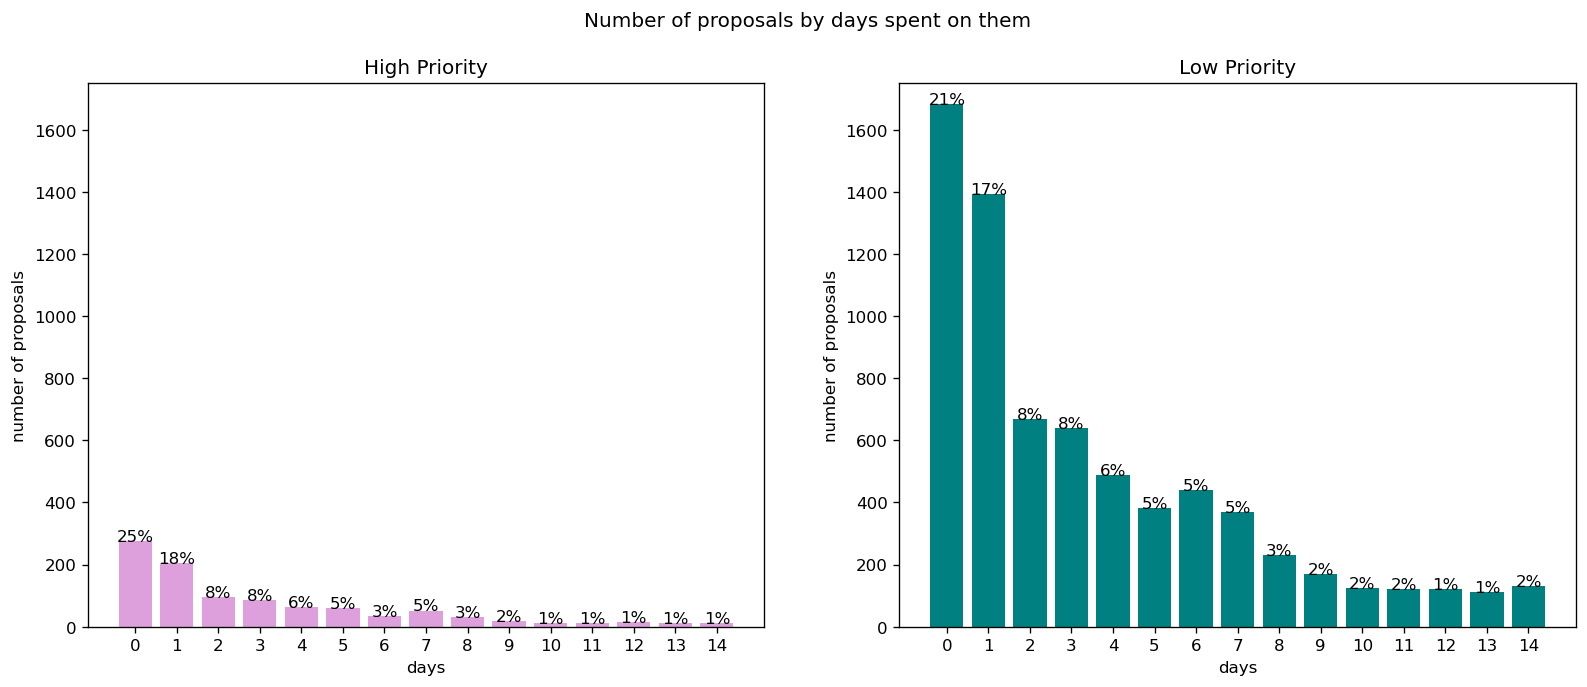

In [34]:
high_priority_list = []
low_priority_list = []
high_priority_percentage = []
low_priority_percentage = []

num_days = 15

for i in range(num_days):
    high_priority_list.append(len(high_priority_deals[high_priority_deals['Proposal Send Time ID'] == i]))
    low_priority_list.append(len(low_priority_deals[low_priority_deals['Proposal Send Time ID'] == i]))
                              
    high_priority_percentage.append(round(len(high_priority_deals[high_priority_deals['Proposal Send Time ID'] == i]) 
                                          / len(high_priority_deals), 4) * 100)
    low_priority_percentage.append(round(len(low_priority_deals[low_priority_deals['Proposal Send Time ID'] == i]) 
                                           / len(low_priority_deals), 4) * 100)
d = np.arange(0, num_days)

fig, axs = plt.subplots(1, 2, figsize=(16,6), dpi=120)

plt.suptitle('Number of proposals by days spent on them')

axs[0].set_ylim(top=1750)
axs[0].set_title('High Priority')
axs[0].set_xlabel('days')
axs[0].set_ylabel('number of proposals')
axs[0].set_xticks(d)
axs[0].bar(d, high_priority_list, color='plum')

patches1 = axs[0].patches
for i in range(len(patches1)):
    x = patches1[i].get_x() + patches1[i].get_width() / 2
    y = patches1[i].get_height() + .05
    axs[0].annotate('{:.0f}%'.format(high_priority_percentage[i]), (x, y), ha='center')

axs[1].set_ylim(top=1750)
axs[1].set_title('Low Priority')
axs[1].set_xlabel('days')
axs[1].set_ylabel('number of proposals')
axs[1].set_xticks(d)
axs[1].bar(d, low_priority_list, color='teal')

patches2 = axs[1].patches
for i in range(len(patches2)):
    x = patches2[i].get_x() + patches2[i].get_width() / 2
    y = patches2[i].get_height() + .05
    axs[1].annotate('{:.0f}%'.format(low_priority_percentage[i]), (x, y), ha='center')

Построим гистограмму, показывающую разницу между соответствующими долями высокого и низкого приоритетов

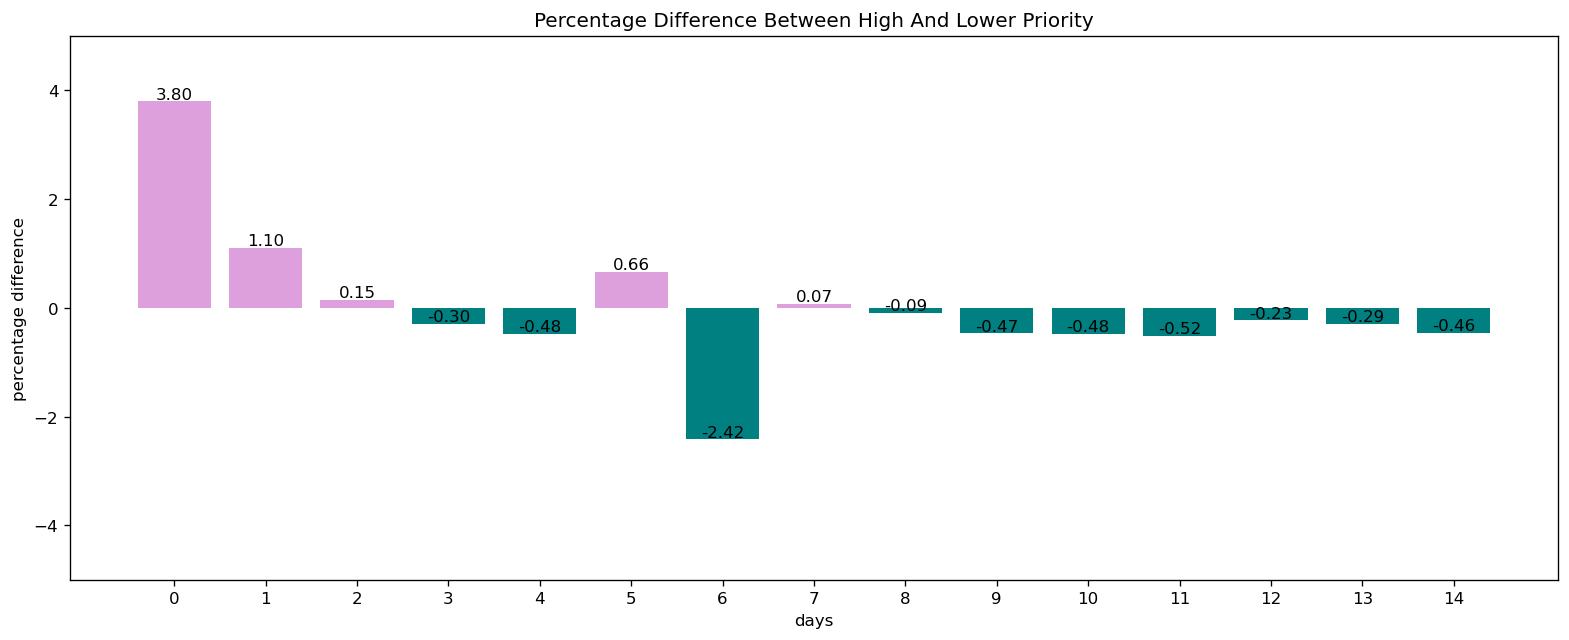

In [35]:
percentage_difference = [k - j for k, j in zip(high_priority_percentage, low_priority_percentage)]

color = []
for i in range(num_days):
    if (percentage_difference[i] > 0):
        color.append('plum')
    else: color.append('teal')

fig, axs = plt.subplots(1, 1, figsize=(16,6), dpi=120)

axs.set_ylim(bottom=-5, top=5)
axs.set_title('Percentage Difference Between High And Lower Priority')
axs.set_xlabel('days')
axs.set_ylabel('percentage difference')
axs.set_xticks(d)
axs.bar(d, percentage_difference, color=color)

patches = axs.patches
for i in range(len(patches)):
    x = patches[i].get_x() + patches[i].get_width() / 2
    y = patches[i].get_height() + .05
    axs.annotate('{:.2f}'.format(percentage_difference[i]), (x, y), ha='center')

In [36]:
def percentage_for_days(percentage_list):
    p1 = 0; p2 = 0; p3 = 0
    for i in range(len(percentage_list)):
        if (i <= 3):
            p1 += percentage_list[i]
        elif (i > 3 & i <= 14):
            p2 += percentage_list[i]
    p3 = round(100 - p1 - p2, 2)
    return p1, p2, p3

high_p1, high_p2, high_p3 = percentage_for_days(high_priority_percentage)
low_p1, low_p2, low_p3 = percentage_for_days(low_priority_percentage)

print('Days\tHigh Priority\tLow Priority\tDifference')
print("0-3:\t", high_p1, '\t\t', low_p1, '\t\t', round(high_p1 - low_p1, 2))
print('4-14:\t', high_p2, '\t\t', low_p2, '\t\t', round(high_p2 - low_p2, 2))
print('15+:\t', high_p3, '\t\t', low_p3, '\t\t', round(high_p3 - low_p3, 2))

Days	High Priority	Low Priority	Difference
0-3:	 59.31 		 54.56 		 4.75
4-14:	 28.71 		 33.42 		 -4.71
15+:	 11.98 		 12.02 		 -0.04


Таким образом, мы видим, что процент КП, выставляемых *быстро*, выше для сделок с высоким приоритетом, а процент КП, выставляемых со *средней скоростью* и *долго*, выше для сделок с более низким приоритетом.  
В целом делаем вывод, что **инструмент приоритизации работает плохо**, так как разница между найденными показателями невелика (примерно **5%** для КП, выставляемых быстро).